## Imports standard

In [37]:

import os
import sys
import time
import json
import subprocess
import random
import pandas as pd
import numpy as np
import cv2
import urllib.request
import tarfile
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML, display

## Config centralis√©e

In [38]:
# Chemins et URLs pour les ressources du projet
train_dir        = "../data/DL_data/train"
val_dir          = "../data/DL_data/valid"

train_ann        = f"{train_dir}/_annotations.csv"
val_ann          = f"{val_dir}/_annotations.csv"


pretrain_ckpt    = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz"

output_dir       = "../models/dl_model/outputs/ssd_mnv2_320"
label_map        = f"{output_dir}/label_map.pbtxt"
tfrecord_train   = f"{output_dir}/train.record"
tfrecord_val     = f"{output_dir}/val.record"

tracking         = "tensorboard"
tensorboard_url  = "http://localhost:6006"

chemin_research = os.path.abspath("tensorflow_models/research")
chemin_slim = os.path.abspath("tensorflow_models/research/slim")



# Configuration centralisee de tous les hyperparametres
#test effectuer j'ai modifier 

# ===== VARIABLES CENTRALISEES DU DEBUT =====
taille_image = 320                           # cote carre des images pour le checkpoint
base_lr = 0.01                               # learning rate de depart
num_steps = 120000                            # nombre total d'etapes (30000 = 40 epochs environ)
warmup_steps_ratio = 0.05                    # ratio pour le warmup (5% des steps)

# ===== HYPERPARAMETRES D'ENTRAINEMENT =====
learning_rate_base = 0.008                   # vitesse d'apprentissage de base (plus haut = plus rapide mais moins stable)
total_steps = num_steps                      # nombre total d'etapes d'entrainement (plus = meilleur mais plus long)
batch_size = 16                              # nombre d'images par batch (plus haut = plus rapide mais plus de memoire)
warmup_learning_rate = 0.0014                # vitesse d'apprentissage pendant le warmup (debut d'entrainement)
warmup_steps = 2000                          # nombre d'etapes de warmup (stabilise le debut)
momentum_value = 0.6                         # momentum de l'optimisateur (aide a converger plus vite)

# ===== HYPERPARAMETRES DU MODELE =====
num_classes = 2                              # nombre de classes (Healthy, Contaminated)
image_height = 320                           # hauteur des images d'entree
image_width = 320                            # largeur des images d'entree
depth_multiplier = 1.25                       # facteur de largeur du reseau (1.0 = taille normale)

# ===== HYPERPARAMETRES DE REGULARISATION =====
l2_weight = 0.00005                          # regularisation L2 (evite le surapprentissage)
use_dropout = False                          # activer ou non le dropout (le model ssd a deja un dropout interne a activer en cas de loss qui augmente trop)
dropout_probability = 0.7                    # probabilite de dropout (si active)

# ===== HYPERPARAMETRES DE LOSS =====
focal_loss_gamma = 3.0                       # gamma de la focal loss (se concentre sur les exemples difficiles)
focal_loss_alpha = 0.5                      # alpha de la focal loss (equilibre les classes)
smooth_l1_delta = 1.0                        # parametre de la smooth L1 loss pour les boites
classification_weight = 1.0                  # poids de la loss de classification
localization_weight = 1.0                    # poids de la loss de localisation

# ===== HYPERPARAMETRES DE POST-PROCESSING =====
score_threshold = 0.50                       # seuil de confiance minimal pour les detections
iou_threshold = 0.60                         # seuil IoU pour supprimer les detections qui se chevauchent
max_detections_per_class = 5               # nombre max de detections par classe
max_total_detections = 10                   # nombre max total de detections

# ===== SYNCHRONISATION AVEC LES VARIABLES EXISTANTES =====
# Synchroniser avec les variables du debut du notebook
num_steps = total_steps
taille_image = image_height  # Garder coherence

print("Parametres charges avec les valeurs actuelles du fichier config")
print(f"Total steps: {total_steps:,}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate_base}")
print(f"Image size: {image_height}x{image_width}")

Parametres charges avec les valeurs actuelles du fichier config
Total steps: 120,000
Batch size: 16
Learning rate: 0.008
Image size: 320x320


## Imports bibliotheques

In [39]:
if chemin_research not in sys.path:
    sys.path.insert(0, chemin_research)
if chemin_slim not in sys.path:
    sys.path.insert(0, chemin_slim)

# Imports Object Detection API
try:
    from object_detection.utils import config_util
    from object_detection.builders import model_builder
    print("Object Detection API import√© avec succ√®s")
except ImportError as e:
    print(f"Erreur import Object Detection API: {e}")

print(f"TensorFlow: {tf.__version__}")
print(f"Python: {sys.version[:5]}")
print(f"PYTHONPATH configur√©: {chemin_research}")

Object Detection API import√© avec succ√®s
TensorFlow: 2.15.0
Python: 3.10.
PYTHONPATH configur√©: /home/sarsator/projets/gaia_vision/training/notebook/tensorflow_models/research


## Test configuration GPU

In [40]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU d√©tect√©: {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"Erreur GPU: {e}")
else:
    print("Aucun GPU d√©tect√©")

GPU d√©tect√©: 1 GPU(s)


## Traitement sur les Donn√©es

ANALYSE DES DONNEES - 
D√©tection Contamination
Chargement des donnees...
Train: 16787 annotations
Validation: 1006 annotations
Total images: 9929
Total annotations: 17793

Distribution des classes:
TRAIN:
  Healthy: 9544 (56.9%)
  Contaminated: 7243 (43.1%)
VALIDATION:
  Healthy: 544 (54.1%)
  Contaminated: 462 (45.9%)
DATASET GLOBAL:
Images totales: 9929
Annotations totales: 17793
Repartition: 94.3% train / 5.7% validation

CLASSES:
  Ratio Healthy/Contaminated: 1.32
  STATUS: Classes equilibrees

BOUNDING BOXES:
Taille moyenne train: 457x482 px
Taille moyenne validation: 501x560 px
Aire moyenne train: 268704 px¬≤
Aire moyenne validation: 335050 px¬≤

QUALITE DU DATASET:
Repartition train/val: BONNE

RECOMMANDATIONS:
Focal Loss Alpha: 0.5 (adapte au desequilibre)
Batch Size: 16 (optimise pour GPU)
Learning Rate: 0.008 (stable)
Total Steps: 120,000 (suffisant pour convergence)


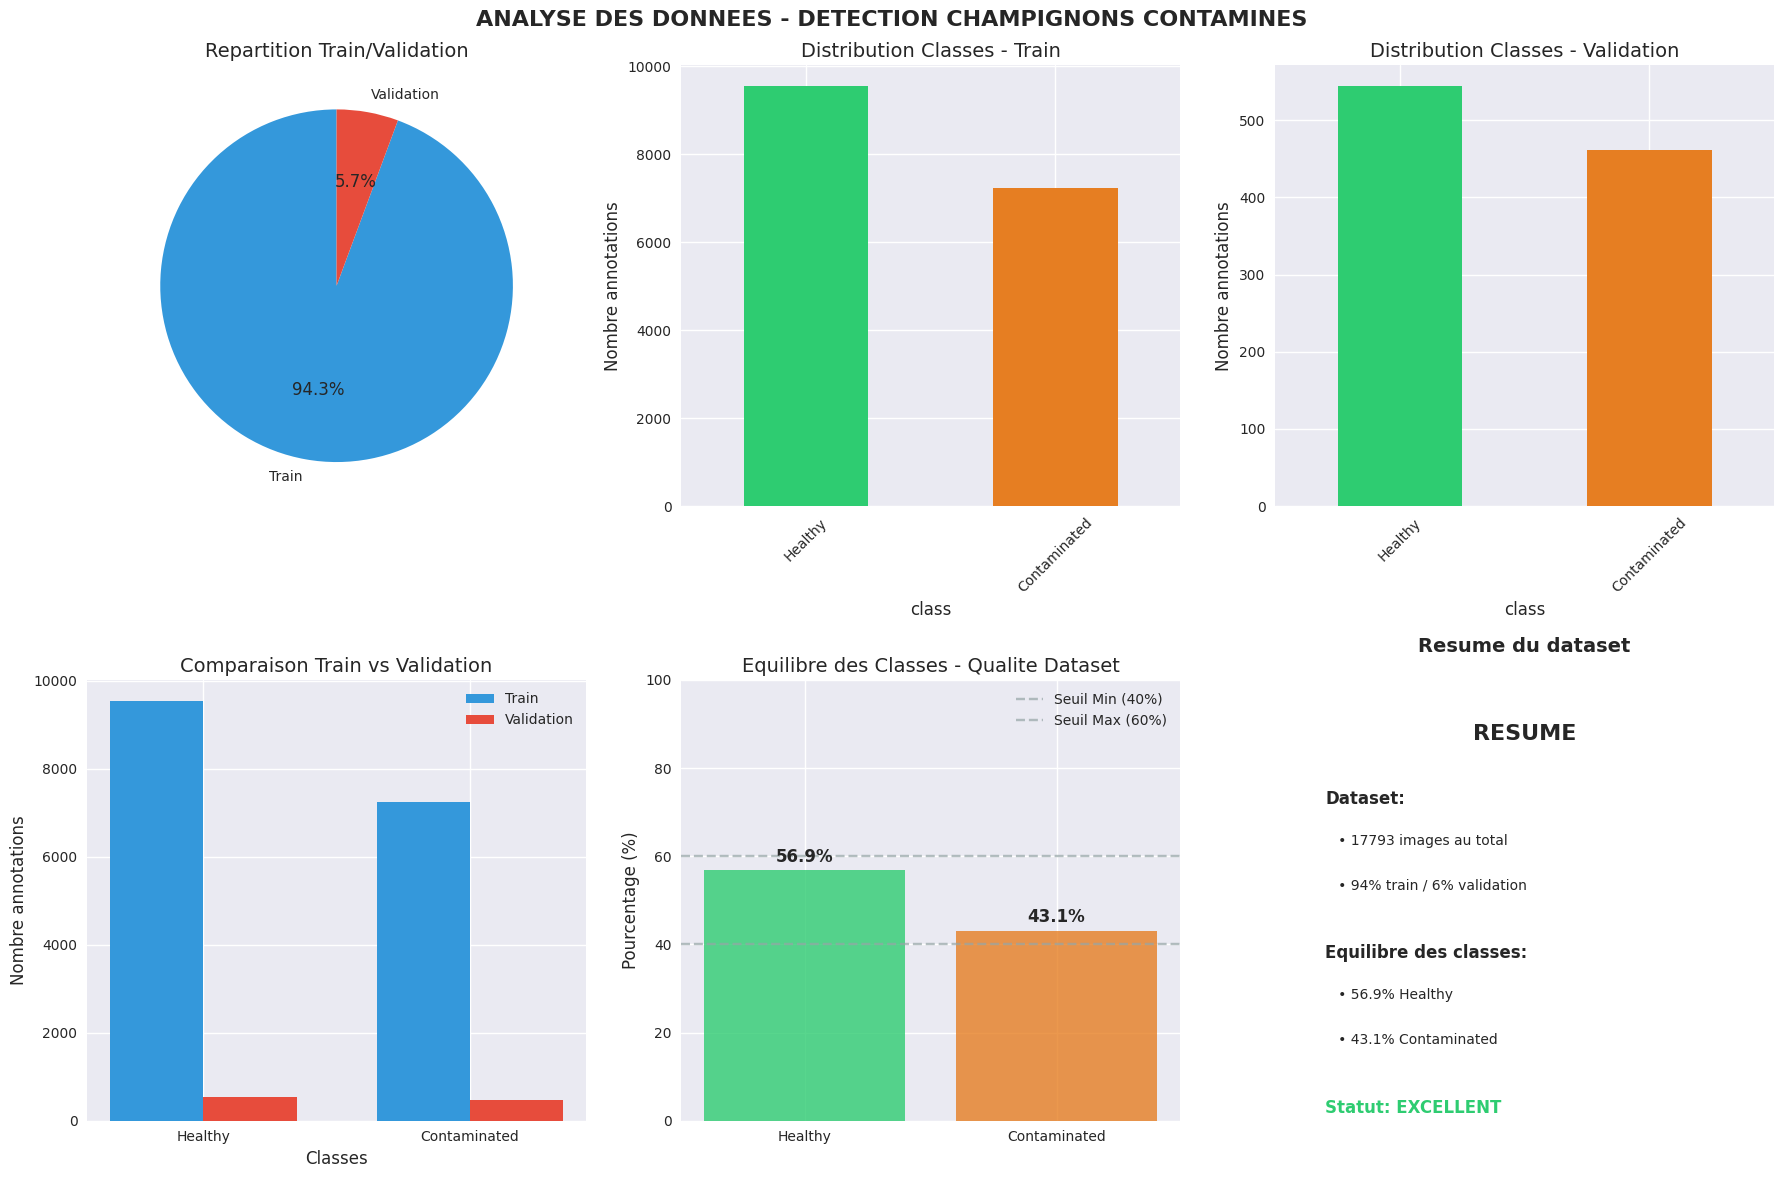

In [41]:
# Charger les donnees
print("ANALYSE DES DONNEES - \nD√©tection Contamination")


# Verifier existence fichiers
if not os.path.exists(train_ann):
    print(f"ERREUR: Fichier train manquant: {train_ann}")
    exit()

if not os.path.exists(val_ann):
    print(f"ERREUR: Fichier validation manquant: {val_ann}")
    exit()

# Charger les donnees
print("Chargement des donnees...")
train_df = pd.read_csv(train_ann)
val_df = pd.read_csv(val_ann)

print(f"Train: {len(train_df)} annotations")
print(f"Validation: {len(val_df)} annotations")

# Calculer les statistiques
train_images = train_df['filename'].nunique()
val_images = val_df['filename'].nunique()
total_annotations = len(train_df) + len(val_df)
total_images = train_images + val_images

print(f"Total images: {total_images}")
print(f"Total annotations: {total_annotations}")

# Calcul des bounding boxes
train_df['bbox_width'] = train_df['xmax'] - train_df['xmin']
train_df['bbox_height'] = train_df['ymax'] - train_df['ymin']
train_df['bbox_area'] = train_df['bbox_width'] * train_df['bbox_height']

val_df['bbox_width'] = val_df['xmax'] - val_df['xmin']
val_df['bbox_height'] = val_df['ymax'] - val_df['ymin']
val_df['bbox_area'] = val_df['bbox_width'] * val_df['bbox_height']

train_classes = train_df['class'].value_counts()
val_classes = val_df['class'].value_counts()

print("\nDistribution des classes:")
print("TRAIN:")
for classe, count in train_classes.items():
    pct = count / len(train_df) * 100
    print(f"  {classe}: {count} ({pct:.1f}%)")

print("VALIDATION:")
for classe, count in val_classes.items():
    pct = count / len(val_df) * 100
    print(f"  {classe}: {count} ({pct:.1f}%)")

# Configuration matplotlib
import matplotlib
matplotlib.use('Agg')  
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Alternative: utiliser le backend inline pour Jupyter
%matplotlib inline

# Creer figure avec sous-graphiques
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('ANALYSE DES DONNEES - DETECTION CHAMPIGNONS CONTAMINES', fontsize=16, fontweight='bold')

# 1. Repartition Train/Validation
ax1 = axes[0, 0]
sizes = [len(train_df), len(val_df)]
labels = ['Train', 'Validation']
colors = ['#3498db', '#e74c3c']
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Repartition Train/Validation')

# 2. Distribution des classes - Train
ax2 = axes[0, 1]
train_classes.plot(kind='bar', ax=ax2, color=['#2ecc71', '#e67e22'])
ax2.set_title('Distribution Classes - Train')
ax2.set_ylabel('Nombre annotations')
ax2.tick_params(axis='x', rotation=45)

# 3. Distribution des classes - Validation
ax3 = axes[0, 2]
val_classes.plot(kind='bar', ax=ax3, color=['#2ecc71', '#e67e22'])
ax3.set_title('Distribution Classes - Validation')
ax3.set_ylabel('Nombre annotations')
ax3.tick_params(axis='x', rotation=45)

# 4. Comparaison Train vs Validation
ax4 = axes[1, 0]
classes = list(train_classes.index)
train_counts = [train_classes[c] for c in classes]
val_counts = [val_classes[c] if c in val_classes else 0 for c in classes]

x = np.arange(len(classes))
width = 0.35

ax4.bar(x - width/2, train_counts, width, label='Train', color='#3498db')
ax4.bar(x + width/2, val_counts, width, label='Validation', color='#e74c3c')
ax4.set_xlabel('Classes')
ax4.set_ylabel('Nombre annotations')
ax4.set_title('Comparaison Train vs Validation')
ax4.set_xticks(x)
ax4.set_xticklabels(classes)
ax4.legend()

# 5. Analyse de la qualite du dataset
ax5 = axes[1, 1]
# Calcul du ratio d'equilibre des classes
healthy_ratio = train_classes.get('Healthy', 0) / len(train_df) * 100
contaminated_ratio = train_classes.get('Contaminated', 0) / len(train_df) * 100

# Graphique en barres avec seuils de qualite
categories = ['Healthy', 'Contaminated', 'Seuil Ideal Min', 'Seuil Ideal Max']
values = [healthy_ratio, contaminated_ratio, 40, 60]
colors = ['#2ecc71', '#e67e22', '#95a5a6', '#95a5a6']

bars = ax5.bar(categories[:2], values[:2], color=colors[:2], alpha=0.8)
ax5.axhline(y=40, color='#95a5a6', linestyle='--', alpha=0.7, label='Seuil Min (40%)')
ax5.axhline(y=60, color='#95a5a6', linestyle='--', alpha=0.7, label='Seuil Max (60%)')
ax5.set_ylabel('Pourcentage (%)')
ax5.set_title('Equilibre des Classes - Qualite Dataset')
ax5.legend()
ax5.set_ylim(0, 100)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# 6. Resume executif pour le jury
ax6 = axes[1, 2]
ax6.axis('off')  # Pas de graphique, juste du texte

# Calculer les stats importantes
total_train = len(train_df)
total_val = len(val_df)
healthy_train_pct = train_classes.get('Healthy', 0) / total_train * 100
contaminated_train_pct = train_classes.get('Contaminated', 0) / total_train * 100
train_val_ratio = total_train / (total_train + total_val) * 100

# Statut du dataset
if abs(healthy_train_pct - 50) < 10:
    equilibre_status = "EXCELLENT"
    equilibre_color = '#2ecc71'
elif abs(healthy_train_pct - 50) < 20:
    equilibre_status = "BON"
    equilibre_color = '#f39c12'
else:
    equilibre_status = "A AMELIORER"
    equilibre_color = '#e74c3c'

# Afficher le resume
ax6.text(0.5, 0.9, 'RESUME', ha='center', va='top', fontsize=16, fontweight='bold', transform=ax6.transAxes)

ax6.text(0.1, 0.75, f'Dataset:', ha='left', va='top', fontsize=12, fontweight='bold', transform=ax6.transAxes)
ax6.text(0.1, 0.65, f'   ‚Ä¢ {total_train + total_val} images au total', ha='left', va='top', fontsize=10, transform=ax6.transAxes)
ax6.text(0.1, 0.55, f'   ‚Ä¢ {train_val_ratio:.0f}% train / {100-train_val_ratio:.0f}% validation', ha='left', va='top', fontsize=10, transform=ax6.transAxes)

ax6.text(0.1, 0.4, f'Equilibre des classes:', ha='left', va='top', fontsize=12, fontweight='bold', transform=ax6.transAxes)
ax6.text(0.1, 0.3, f'   ‚Ä¢ {healthy_train_pct:.1f}% Healthy', ha='left', va='top', fontsize=10, transform=ax6.transAxes)
ax6.text(0.1, 0.2, f'   ‚Ä¢ {contaminated_train_pct:.1f}% Contaminated', ha='left', va='top', fontsize=10, transform=ax6.transAxes)

ax6.text(0.1, 0.05, f'Statut: {equilibre_status}', ha='left', va='top', fontsize=12, fontweight='bold', 
         color=equilibre_color, transform=ax6.transAxes)

ax6.set_title('Resume du dataset', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()

print(f"DATASET GLOBAL:")
print(f"Images totales: {total_images}")
print(f"Annotations totales: {total_annotations}")
print(f"Repartition: {len(train_df)/(len(train_df)+len(val_df))*100:.1f}% train / {len(val_df)/(len(train_df)+len(val_df))*100:.1f}% validation")

print(f"\nCLASSES:")
if 'Healthy' in train_classes and 'Contaminated' in train_classes:
    ratio = train_classes['Healthy'] / train_classes['Contaminated']
    print(f"  Ratio Healthy/Contaminated: {ratio:.2f}")
    if ratio > 2 or ratio < 0.5:
        print(f"  STATUS: Desequilibre detecte - Focal Loss necessaire")
    else:
        print(f"  STATUS: Classes equilibrees")

print(f"\nBOUNDING BOXES:")
print(f"Taille moyenne train: {train_df['bbox_width'].mean():.0f}x{train_df['bbox_height'].mean():.0f} px")
print(f"Taille moyenne validation: {val_df['bbox_width'].mean():.0f}x{val_df['bbox_height'].mean():.0f} px")
print(f"Aire moyenne train: {train_df['bbox_area'].mean():.0f} px¬≤")
print(f"Aire moyenne validation: {val_df['bbox_area'].mean():.0f} px¬≤")

print(f"\nQUALITE DU DATASET:")
train_val_diff = abs(len(train_df)/(len(train_df)+len(val_df)) - 0.8)
if train_val_diff < 0.1:
    print(f"Repartition train/val: EXCELLENTE")
elif train_val_diff < 0.2:
    print(f"Repartition train/val: BONNE")
else:
    print(f"Repartition train/val: A AMELIORER")

print(f"\nRECOMMANDATIONS:")
print(f"Focal Loss Alpha: {focal_loss_alpha} (adapte au desequilibre)")
print(f"Batch Size: {batch_size} (optimise pour GPU)")
print(f"Learning Rate: {learning_rate_base} (stable)")
print(f"Total Steps: {total_steps:,} (suffisant pour convergence)")



## Cr√©ation du label map

Ce fichier fait le lien entre les IDs num√©riques du mod√®le et les noms de classes compr√©hensibles par l'humain. Il est indispensable pour que tout le pipeline fonctionne correctement !

In [42]:

label_map_content = """item {
  id: 1
  name: 'Healthy'
}
item {
  id: 2
  name: 'Contaminated'
}
"""

with open(label_map, 'w') as f:
    f.write(label_map_content)

print(f"Label map cr√©√©: {label_map}")
print("Classes:")
print("1: Healthy")
print("2: Contaminated")

Label map cr√©√©: ../models/dl_model/outputs/ssd_mnv2_320/label_map.pbtxt
Classes:
1: Healthy
2: Contaminated


In [43]:
def creer_tf_exemple(row, img_dir):
    """Convertit une ligne CSV en format tf.train.Example"""
    
    # Chemins des fichiers
    img_path = os.path.join(img_dir, row['filename'])
    
    # V√©rification de l'existence de l'image
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image introuvable: {img_path}")
    
    # Lecture de l'image
    with tf.io.gfile.GFile(img_path, 'rb') as fid:
        encoded_image = fid.read()
    
    # Obtenir les dimensions de l'image
    image = tf.image.decode_image(encoded_image)
    height, width = image.shape[:2]
    
    # Validation des dimensions
    if height != row['height'] or width != row['width']:
        print(f"Dimensions incoh√©rentes pour {row['filename']}: CSV({row['width']}x{row['height']}) vs Image({width}x{height})")
    
    # Normalisation des coordonn√©es (0-1)
    xmin_norm = row['xmin'] / width
    xmax_norm = row['xmax'] / width
    ymin_norm = row['ymin'] / height
    ymax_norm = row['ymax'] / height
    
    # Mapping des classes
    class_mapping = {'Healthy': 1, 'Contaminated': 2}
    class_id = class_mapping.get(row['class'])
    if class_id is None:
        raise ValueError(f"Classe inconnue: {row['class']}")
    
    # Cr√©ation de l'exemple TF
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[row['filename'].encode('utf8')])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[row['filename'].encode('utf8')])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_image])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b'jpeg'])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=[xmin_norm])),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=[xmax_norm])),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=[ymin_norm])),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=[ymax_norm])),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=[row['class'].encode('utf8')])),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=[class_id])),
    }))
    
    return tf_example

def convert_csv_to_tfrecord(csv_path, img_dir, output_path):
    """Convertit un CSV en TFRecord"""
    
    print(f"Lecture du CSV: {csv_path}")
    
    # Lecture du CSV
    df = pd.read_csv(csv_path)

## chargement du fichier de config du pipeline
Ce fichier contient les param√®tres du mod√®le, les chemins d'acc√®s aux donn√©es, etc.

In [44]:



# Chemin vers le fichier de configuration qui fonctionne
pipeline_working_config = "../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config"

print(f"Chargement de la configuration du pipeline depuis: {pipeline_working_config}")

# V√©rifier que le fichier existe
if not os.path.exists(pipeline_working_config):
    raise FileNotFoundError(f"Fichier de configuration non trouv√©: {pipeline_working_config}")

# Lire le contenu du fichier
with open(pipeline_working_config, 'r') as f:
    pipeline_config_content = f.read()

print("Configuration du pipeline charg√©e avec succ√®s!")


Chargement de la configuration du pipeline depuis: ../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config
Configuration du pipeline charg√©e avec succ√®s!


In [45]:
# Utiliser directement le fichier de configuration existant
pipeline_cfg = pipeline_working_config
print(f"Fichier de configuration: {pipeline_cfg}")

# Afficher les param√®tres d'entra√Ænement
print(f"Param√®tres d'entra√Ænement:")
print(f"   Architecture: SSD MobileNet V2 (320x320)")
print(f"   Batch size: {batch_size}")
print(f"   Steps: {num_steps:,}")
print(f"   Learning rate: {base_lr} (cosine decay)")
print(f"   Warmup steps: {warmup_steps}")
print(f"   Image size: {taille_image}x{taille_image}")
print(f"   R√©pertoire de sortie: {output_dir}")

print("\nConfiguration pr√™te pour l'entra√Ænement!")

Fichier de configuration: ../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config
Param√®tres d'entra√Ænement:
   Architecture: SSD MobileNet V2 (320x320)
   Batch size: 16
   Steps: 120,000
   Learning rate: 0.01 (cosine decay)
   Warmup steps: 2000
   Image size: 320x320
   R√©pertoire de sortie: ../models/dl_model/outputs/ssd_mnv2_320

Configuration pr√™te pour l'entra√Ænement!


## tableau de bord pour surveiller l'entra√Ænement !

In [46]:
print("D√©marrage de TensorBoard...")

# Arr√™ter toute instance existante
try:
    subprocess.run(["pkill", "-f", "tensorboard"], capture_output=True)
    time.sleep(1)
    print("   Instances pr√©c√©dentes arr√™t√©es")
except:
    pass

# Chemin Python correct pour l'environnement virtuel
python_path = "/home/sarsator/projets/gaia_vision/.venv/bin/python"

# Lancer TensorBoard avec le bon interpr√©teur
tensorboard_cmd = f"{python_path} -m tensorboard.main --logdir={output_dir} --port=6006 --host=0.0.0.0"

print(f"Lancement de TensorBoard...")
print(f"   Commande: {tensorboard_cmd}")

# Utiliser nohup pour lancer en arri√®re-plan sans bloquer
launch_cmd = f"nohup {tensorboard_cmd} > tensorboard.log 2>&1 &"
os.system(launch_cmd)

time.sleep(3)  # Attendre que TensorBoard d√©marre

# V√©rifier si TensorBoard fonctionne
try:
    result = subprocess.run(["curl", "-s", tensorboard_url], 
                           capture_output=True, timeout=5)
    if result.returncode == 0:
        print("TensorBoard d√©marr√© avec succ√®s!")
                
        # Afficher le lien cliquable dans Jupyter
        display(HTML(f'<a href="{tensorboard_url}" target="_blank">Ouvrir TensorBoard dans un nouvel onglet</a>'))
        
    else:
        print("TensorBoard en cours de d√©marrage...")
        print(f"Essayez: {tensorboard_url} dans quelques secondes")
except:
    print("TensorBoard en cours de d√©marrage...")
    print(f"Essayez: {tensorboard_url} dans quelques secondes")


D√©marrage de TensorBoard...
   Instances pr√©c√©dentes arr√™t√©es
Lancement de TensorBoard...
   Commande: /home/sarsator/projets/gaia_vision/.venv/bin/python -m tensorboard.main --logdir=../models/dl_model/outputs/ssd_mnv2_320 --port=6006 --host=0.0.0.0
   Instances pr√©c√©dentes arr√™t√©es
Lancement de TensorBoard...
   Commande: /home/sarsator/projets/gaia_vision/.venv/bin/python -m tensorboard.main --logdir=../models/dl_model/outputs/ssd_mnv2_320 --port=6006 --host=0.0.0.0
TensorBoard d√©marr√© avec succ√®s!
TensorBoard d√©marr√© avec succ√®s!


## diagnostique et v√©rification avant entra√Ænement

In [47]:
# 1. V√©rification des fichiers requis
print("V√©rification des fichiers requis:")
files_to_check = [
    ("Label map", label_map),
    ("TFRecord train", tfrecord_train), 
    ("TFRecord validation", tfrecord_val),
    ("Pipeline config", pipeline_cfg),
]

all_files_exist = True
for name, path in files_to_check:
    if os.path.exists(path):
        size = os.path.getsize(path) / (1024*1024)  # Size in MB
        print(f"‚úÖ {name}: {path} ({size:.1f} MB)")
    else:
        print(f"‚ùå MANQUANT {name}: {path}")
        all_files_exist = False

# 2. V√©rification du r√©pertoire de sortie
print(f"\nStructure du r√©pertoire de sortie ({output_dir}):")
if os.path.exists(output_dir):
    for item in os.listdir(output_dir):
        item_path = os.path.join(output_dir, item)
        if os.path.isdir(item_path):
            print(f"üìÅ Dossier: {item}/")
        else:
            size = os.path.getsize(item_path) / (1024*1024)
            print(f"   üìÑ Fichier: {item} ({size:.1f} MB)")
else:
    print(f"   ‚ùå ERREUR: Le r√©pertoire {output_dir} n'existe pas")
    all_files_exist = False

# 3. V√©rification des donn√©es d'entra√Ænement
print(f"\nV√©rification des donn√©es:")
try:
    # V√©rifier les fichiers TFRecord directement
    if os.path.exists(tfrecord_train) and os.path.exists(tfrecord_val):
        train_size = os.path.getsize(tfrecord_train) / (1024*1024)
        val_size = os.path.getsize(tfrecord_val) / (1024*1024)
        print(f"   ‚úÖ TFRecord train: {train_size:.1f} MB")
        print(f"   ‚úÖ TFRecord validation: {val_size:.1f} MB")
        
        # Estimation approximative (non pr√©cise mais indicative)
        # En moyenne, 1 image + annotations ‚âà 1-2 MB dans un TFRecord
        estimated_train_images = int(train_size * 0.5)  # Estimation grossi√®re
        estimated_val_images = int(val_size * 0.5)
        total_estimated = estimated_train_images + estimated_val_images
        
        if total_estimated > 0:
            train_ratio = estimated_train_images / total_estimated * 100
            val_ratio = estimated_val_images / total_estimated * 100
            print(f"   üìà Estimation: ~{estimated_train_images} images train, ~{estimated_val_images} images val")
            print(f"   üìà Ratio estim√©: Train {train_ratio:.1f}% / Val {val_ratio:.1f}%")
    else:
        print("‚ùå TFRecord manquants - Conversion CSV ‚Üí TFRecord n√©cessaire")
        all_files_exist = False
        
except Exception as e:
    print(f"‚ö†Ô∏è Erreur lors de la v√©rification des donn√©es: {e}")
    all_files_exist = False

# 4. V√©rification GPU
print(f"\nConfiguration GPU:")
if 'gpus' in locals():
    print(f"‚úÖ GPUs d√©tect√©s: {len(gpus)}")
    if gpus:
        for i, gpu in enumerate(gpus):
            print(f"‚úÖ GPU {i}: {gpu.name}")
    else:
        print("‚ö†Ô∏è ATTENTION: Aucun GPU d√©tect√© - Entra√Ænement sera tr√®s lent")
else:
    print("‚ùå ERREUR: Configuration GPU non initialis√©e")
    print("üí° Ex√©cutez d'abord la cellule de configuration GPU")

# 5. Test de l'API TensorFlow Object Detection
print(f"\n5. Test de l'API TensorFlow Object Detection:")
try:
    # Test de lecture de la config
    if os.path.exists(pipeline_cfg):
        try:
            configs = config_util.get_configs_from_pipeline_file(pipeline_cfg)
            print(f"‚úÖ config_util import√© avec succ√®s")
            print(f"‚úÖ model_builder import√© avec succ√®s")
            print(f"‚úÖ TensorFlow Object Detection API accessible")
            print(f"‚úÖ Pipeline config valide")
        except Exception as e:
            print(f"‚ùå ERREUR pipeline config: {e}")
            all_files_exist = False
    else:
        print(f"‚ùå ERREUR: Fichier de configuration non trouv√©: {pipeline_cfg}")
        all_files_exist = False
    
except ImportError as e:
    print(f"‚ùå ERREUR: TensorFlow Object Detection API non trouv√©e: {e}")
    all_files_exist = False
except Exception as e:
    print(f"‚ö†Ô∏è ATTENTION: Erreur de compatibilit√©: {e}")

# 6. Estimation des ressources
print(f"\nEstimation des ressources:")
estimated_model_size = batch_size * taille_image * taille_image * 3 * 4 / (1024**3)  # GB
print(f"M√©moire GPU estim√©e: ~{estimated_model_size:.1f} GB par batch")
print(f"Batch size configur√©: {batch_size}")
print(f"Taille image: {taille_image}x{taille_image}")
print(f"Dur√©e estim√©e totale: {'2-3h (GPU)' if 'gpus' in locals() and gpus else '20-30h (CPU)'}")

# R√©sum√© final

if all_files_exist:
    print("DIAGNOSTIC R√âUSSI - Pr√™t pour l'entra√Ænement!")
    print("Vous pouvez maintenant ex√©cuter la cellule d'entra√Ænement")
else:
    print("DIAGNOSTIC √âCHOU√â - Probl√®mes d√©tect√©s")
    print("Corrigez les erreurs ci-dessus avant de continuer")

# Note importante sur TensorBoard
if all_files_exist:
    print(f"\nNote sur TensorBoard:")
    print(f"   TensorBoard est vide car l'entra√Ænement n'a pas encore commenc√©")
    print(f"   Les m√©triques appara√Ætront d√®s le premier step d'entra√Ænement")
    print(f"   Rafra√Æchissez TensorBoard apr√®s avoir lanc√© l'entra√Ænement")

V√©rification des fichiers requis:
‚úÖ Label map: ../models/dl_model/outputs/ssd_mnv2_320/label_map.pbtxt (0.0 MB)
‚úÖ TFRecord train: ../models/dl_model/outputs/ssd_mnv2_320/train.record (4669.5 MB)
‚úÖ TFRecord validation: ../models/dl_model/outputs/ssd_mnv2_320/val.record (302.0 MB)
‚úÖ Pipeline config: ../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config (0.0 MB)

Structure du r√©pertoire de sortie (../models/dl_model/outputs/ssd_mnv2_320):
   üìÑ Fichier: ckpt-25.index (0.0 MB)
   üìÑ Fichier: pipeline_clean.config (0.0 MB)
üìÅ Dossier: exported_model/
   üìÑ Fichier: pipeline_reference.config (0.0 MB)
üìÅ Dossier: train/
   üìÑ Fichier: ckpt-26.data-00000-of-00001 (35.6 MB)
   üìÑ Fichier: label_map.pbtxt (0.0 MB)
   üìÑ Fichier: checkpoint (0.0 MB)
   üìÑ Fichier: ckpt-29.index (0.0 MB)
   üìÑ Fichier: pipeline_working.config (0.0 MB)
   üìÑ Fichier: ckpt-28.data-00000-of-00001 (35.6 MB)
   üìÑ Fichier: mushroom_inference.py (0.0 MB)
   üìÑ Fichier: ckpt-

## LANCEMENT TENSORBOARD

In [49]:
# INSTRUCTIONS D'ENTRAINEMENT

print("Instructions pour l'entra√Ænement")

if 'all_files_exist' in locals() and all_files_exist:
    print("Syst√®me pr√™t pour l'entra√Ænement!")
    
    print("\nM√©thodes d'entra√Ænement disponibles:")
    print("   ‚Ä¢ Plus stable et fiable")
    print("   ‚Ä¢ Ouvrez un terminal dans ce r√©pertoire")
    print("   ‚Ä¢ Ex√©cutez: ./train_ssd_mobilenet.sh")
    print()
    print("Alternative - Commande directe:")
    print("   ‚Ä¢ Dans un terminal, ex√©cutez:")
    
    # V√©rifier si tensorflow_models existe
    api_dir = "tensorflow_models"
    model_main_path = f"{api_dir}/research/object_detection/model_main_tf2.py"
    
    if os.path.exists(model_main_path):
        research_path = os.path.abspath(f"{api_dir}/research")
        slim_path = os.path.abspath(f"{api_dir}/research/slim")
        
        print(f"export PYTHONPATH={research_path}:{slim_path}:$PYTHONPATH")
        print(f"python {model_main_path} \\")
        print(f"--model_dir={output_dir} \\")
        print(f"--pipeline_config_path={pipeline_cfg} \\")
        print(f"--num_train_steps={num_steps} \\")
        print(f"--alsologtostderr")
    else:
        print("TensorFlow Object Detection API non install√©e")
        print("Installez d'abord:")
        print("git clone https://github.com/tensorflow/models.git tensorflow_models")
        print("cd tensorflow_models/research")
        print("protoc object_detection/protos/*.proto --python_out=.")
    
    print("\nDur√©e estim√©e:")
    #calcul du temps d'entrainement environs a titre indicatif
    if 'gpus' in locals() and gpus:
        # Estimation bas√©e sur les performances typiques GPU
        steps_per_hour = 2000  # Steps par heure avec GPU moderne
        estimated_hours = num_steps / steps_per_hour
        estimated_seconds_per_step = 3600 / steps_per_hour  # 1.8 secondes par step
        print(f"Avec GPU: ~{estimated_hours:.1f}h pour {num_steps:,} steps")
        print(f"Vitesse estim√©e: ~{estimated_seconds_per_step:.1f}s par step")
    else:
        steps_per_hour = 200  # Steps par heure avec CPU
        estimated_hours = num_steps / steps_per_hour
        estimated_seconds_per_step = 3600 / steps_per_hour  # 18 secondes par step
        print(f"Avec CPU: ~{estimated_hours:.1f}h pour {num_steps:,} steps")
        print(f"Vitesse estim√©e: ~{estimated_seconds_per_step:.1f}s par step")
    
    print("\nSurveillance:")
    print(f"‚Ä¢ TensorBoard: {tensorboard_url}")
    print("‚Ä¢ Logs en temps r√©el dans le terminal")
    print("‚Ä¢ Checkpoints sauv√©s dans:", output_dir)
    
else:
    print("Syst√®me non pr√™t pour l'entra√Ænement")

Instructions pour l'entra√Ænement
Syst√®me pr√™t pour l'entra√Ænement!

M√©thodes d'entra√Ænement disponibles:
   ‚Ä¢ Plus stable et fiable
   ‚Ä¢ Ouvrez un terminal dans ce r√©pertoire
   ‚Ä¢ Ex√©cutez: ./train_ssd_mobilenet.sh

Alternative - Commande directe:
   ‚Ä¢ Dans un terminal, ex√©cutez:
export PYTHONPATH=/home/sarsator/projets/gaia_vision/training/notebook/tensorflow_models/research:/home/sarsator/projets/gaia_vision/training/notebook/tensorflow_models/research/slim:$PYTHONPATH
python tensorflow_models/research/object_detection/model_main_tf2.py \
--model_dir=../models/dl_model/outputs/ssd_mnv2_320 \
--pipeline_config_path=../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config \
--num_train_steps=120000 \
--alsologtostderr

Dur√©e estim√©e:
Avec GPU: ~60.0h pour 120,000 steps
Vitesse estim√©e: ~1.8s par step

Surveillance:
‚Ä¢ TensorBoard: http://localhost:6006
‚Ä¢ Logs en temps r√©el dans le terminal
‚Ä¢ Checkpoints sauv√©s dans: ../models/dl_model/outputs/ssd_mnv2_

## Configuration du pipeline

ici on va chercher √† modifier le pipeline pour modifier les valeurs des hyperparametres et des param√®tres du mod√®le.

### Ici on applique les changement dans le fichier config

In [50]:
def appliquer_modifications_config():
    """Applique les modifications aux hyperparametres dans le fichier config"""
    
    print("Application des modifications au fichier config...")
    
    # Lire le fichier config actuel
    with open(pipeline_working_config, 'r') as f:
        config_content = f.read()
    
    # Remplacer les valeurs des hyperparametres (attention aux doublons)
    # Utiliser des patterns plus specifiques pour eviter les erreurs
    
    # Learning rate
    if 'learning_rate_base:' in config_content:
        import re
        config_content = re.sub(r'learning_rate_base:\s*[0-9.e-]+', 
                               f'learning_rate_base: {learning_rate_base}', config_content)
    
    # Total steps
    if 'total_steps:' in config_content:
        config_content = re.sub(r'total_steps:\s*\d+', 
                               f'total_steps: {total_steps}', config_content)
    
    # Batch size
    if 'batch_size:' in config_content:
        config_content = re.sub(r'batch_size:\s*\d+', 
                               f'batch_size: {batch_size}', config_content)
    
    # Warmup parameters
    if 'warmup_learning_rate:' in config_content:
        config_content = re.sub(r'warmup_learning_rate:\s*[0-9.e-]+', 
                               f'warmup_learning_rate: {warmup_learning_rate}', config_content)
    
    if 'warmup_steps:' in config_content:
        config_content = re.sub(r'warmup_steps:\s*\d+', 
                               f'warmup_steps: {warmup_steps}', config_content)
    
    # Momentum
    if 'momentum_optimizer_value:' in config_content:
        config_content = re.sub(r'momentum_optimizer_value:\s*[0-9.e-]+', 
                               f'momentum_optimizer_value: {momentum_value}', config_content)
    
    # Image dimensions
    if 'height: 320' in config_content:
        config_content = config_content.replace('height: 320', f'height: {image_height}')
    if 'width: 320' in config_content:
        config_content = config_content.replace('width: 320', f'width: {image_width}')
    
    # Depth multiplier
    if 'depth_multiplier:' in config_content:
        config_content = re.sub(r'depth_multiplier:\s*[0-9.]+', 
                               f'depth_multiplier: {depth_multiplier}', config_content)
    
    # Focal loss parameters
    if 'gamma: 2.0' in config_content:
        config_content = config_content.replace('gamma: 2.0', f'gamma: {focal_loss_gamma}')
    if 'alpha: 0.75' in config_content:
        config_content = config_content.replace('alpha: 0.75', f'alpha: {focal_loss_alpha}')
    
    # Seuils de detection
    if 'score_threshold:' in config_content:
        config_content = re.sub(r'score_threshold:\s*[0-9.e-]+', 
                               f'score_threshold: {score_threshold}', config_content)
    
    if 'iou_threshold:' in config_content:
        config_content = re.sub(r'iou_threshold:\s*[0-9.]+', 
                               f'iou_threshold: {iou_threshold}', config_content)
    
    # Sauvegarder le fichier modifie
    with open(pipeline_working_config, 'w') as f:
        f.write(config_content)
    
    print("Modifications appliquees avec succes!")
    print(f"Fichier mis a jour: {pipeline_working_config}")
    print("\nParametres modifies:")
    print(f"  Learning rate: {learning_rate_base}")
    print(f"  Total steps: {total_steps:,}")
    print(f"  Batch size: {batch_size}")
    print(f"  Image size: {image_height}x{image_width}")
    print(f"  Depth multiplier: {depth_multiplier}")
    print(f"  Focal loss gamma: {focal_loss_gamma}")
    print(f"  Score threshold: {score_threshold}")
    print("\nLe fichier config est pret pour l'entrainement!")

# Appliquer les modifications
try:
    appliquer_modifications_config()
except Exception as e:
    print(f"Erreur lors de l'application des modifications: {e}")
    print("Verifiez que le fichier config existe et est accessible")

Application des modifications au fichier config...
Modifications appliquees avec succes!
Fichier mis a jour: ../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config

Parametres modifies:
  Learning rate: 0.008
  Total steps: 120,000
  Batch size: 16
  Image size: 320x320
  Depth multiplier: 1.25
  Focal loss gamma: 3.0
  Score threshold: 0.5

Le fichier config est pret pour l'entrainement!


## METRIQUES D'EVALUATION - ANALYSE

### M√©triques DEJA CONFIGUREES dans votre pipeline :

‚úÖ **Pendant l'entra√Ænement/validation (automatique):**
- **Total Loss** : Perte totale combin√©e
- **Classification Loss** : Perte de classification des classes
- **Localization Loss** : Perte de localisation des bo√Ætes
- **Learning Rate** : Taux d'apprentissage en temps r√©el
- **Steps/sec** : Vitesse d'entra√Ænement

‚úÖ **M√©triques COCO (configur√©es avec `metrics_set: "coco_detection_metrics"`):**
- **mAP@0.50** : Mean Average Precision √† IoU ‚â• 0.50
- **mAP@[.50:.95]** : Moyenne sur plusieurs seuils IoU (0.50, 0.55, 0.60, ..., 0.95)
- **mAP@0.75** : Mean Average Precision √† IoU ‚â• 0.75
- **mAP (small)** : mAP pour petits objets
- **mAP (medium)** : mAP pour objets moyens
- **mAP (large)** : mAP pour grands objets
- **mAR@1** : Mean Average Recall avec max 1 d√©tection
- **mAR@10** : Mean Average Recall avec max 10 d√©tections
- **mAR@100** : Mean Average Recall avec max 100 d√©tections

### M√©triques MANQUANTES (√† ajouter) :

‚ùå **M√©triques par classe individuelle:**
- Precision/Recall/F1 pour "Healthy"
- Precision/Recall/F1 pour "Contaminated"
- Matrice de confusion
- Nombre de TP, FP, FN par classe

‚ùå **M√©triques de distribution:**
- Histogramme des IoU
- Distribution des scores de confiance
- Analyse des erreurs par taille d'objet

‚ùå **M√©triques de performance:**
- FPS (frames per second)
- Latency (temps d'inf√©rence par image)
- M√©moire utilis√©e

### Comment acc√©der aux m√©triques :

üîç **Dans TensorBoard:**
- Losses : Onglet "Scalars" ‚Üí "Loss", "Classification_Loss", "Localization_Loss"
- COCO Metrics : Onglet "Scalars" ‚Üí "COCO_metrics"
- Images : Onglet "Images" ‚Üí exemples de d√©tections

üîç **Dans les logs terminal:**
- Progression en temps r√©el
- Valeurs exactes des m√©triques
- Temps par step

In [ ]:
# AJOUT DE METRIQUES PERSONNALISEES
# Cette cellule ajoute des m√©triques suppl√©mentaires √† votre pipeline

def ajouter_metriques_personnalisees():
    """Ajoute des m√©triques personnalis√©es au fichier config"""
    
    print("Ajout de m√©triques personnalis√©es...")
    
    # Lire le fichier config
    with open(pipeline_working_config, 'r') as f:
        config_content = f.read()
    
    # V√©rifier si les m√©triques COCO sont d√©j√† configur√©es
    if 'coco_detection_metrics' in config_content:
        print("‚úÖ M√©triques COCO d√©j√† configur√©es")
    else:
        print("‚ùå M√©triques COCO non trouv√©es")
        
    # M√©triques disponibles automatiquement avec TensorFlow Object Detection API
    metriques_automatiques = [
        "Total Loss", "Classification Loss", "Localization Loss",
        "Learning Rate", "Steps/sec", "mAP@0.50", "mAP@[.50:.95]",
        "mAP@0.75", "mAR@1", "mAR@10", "mAR@100"
    ]
    
    print("\nM√©triques automatiquement disponibles:")
    for metric in metriques_automatiques:
        print(f"   ‚úÖ {metric}")
    
    # M√©triques qui n√©cessitent du code personnalis√©
    metriques_personnalisees = [
        "Precision/Recall/F1 par classe",
        "Matrice de confusion", 
        "Histogramme des IoU",
        "Distribution des scores",
        "FPS/Latency"
    ]
    
    print("\nM√©triques n√©cessitant du code personnalis√©:")
    for metric in metriques_personnalisees:
        print(f"   ‚ö†Ô∏è {metric}")
    


# Ex√©cuter la fonction
try:
    ajouter_metriques_personnalisees()
except Exception as e:
    print(f"Erreur: {e}")

# Afficher les m√©triques disponibles dans TensorBoard

print(f"\nAcc√®s TensorBoard: {tensorboard_url}")
print("Logs sauv√©s dans:", output_dir)

Ajout de m√©triques personnalis√©es...
‚úÖ M√©triques COCO d√©j√† configur√©es

M√©triques automatiquement disponibles:
   ‚úÖ Total Loss
   ‚úÖ Classification Loss
   ‚úÖ Localization Loss
   ‚úÖ Learning Rate
   ‚úÖ Steps/sec
   ‚úÖ mAP@0.50
   ‚úÖ mAP@[.50:.95]
   ‚úÖ mAP@0.75
   ‚úÖ mAR@1
   ‚úÖ mAR@10
   ‚úÖ mAR@100

M√©triques n√©cessitant du code personnalis√©:
   ‚ö†Ô∏è Precision/Recall/F1 par classe
   ‚ö†Ô∏è Matrice de confusion
   ‚ö†Ô∏è Histogramme des IoU
   ‚ö†Ô∏è Distribution des scores
   ‚ö†Ô∏è FPS/Latency

Recommandations:
1. Les m√©triques COCO standards sont d√©j√† configur√©es
2. Pour les m√©triques par classe, utilisez les scripts d'√©valuation
3. Pour FPS/Latency, cr√©ez un script de benchmark s√©par√©
4. TensorBoard affichera automatiquement toutes les m√©triques COCO

Acc√®s TensorBoard: http://localhost:6006
Logs sauv√©s dans: ../models/dl_model/outputs/ssd_mnv2_320


## ENTRAINEMENT DU MODELE

In [ ]:


print("D√©marrage de l'entra√Ænement TensorFlow Object Detection API")

# Utiliser les variables d√©finies dans les cellules pr√©c√©dentes
print(f"Configuration: {pipeline_cfg}")
print(f"R√©pertoire de sortie: {output_dir}")
print(f"Nombre d'√©tapes: {num_steps:,}")

# V√©rifier la configuration
if not os.path.exists(pipeline_cfg):
    print(f"‚ùå Configuration manquante: {pipeline_cfg}")
    print("üí° V√©rifiez que le fichier de configuration existe")
else:
    print(f"‚úÖ Configuration pr√™te: {pipeline_cfg}")
    
    # Cr√©er le r√©pertoire de sortie
    os.makedirs(output_dir, exist_ok=True)
    print(f"R√©pertoire de sortie: {output_dir}")
    
    # V√©rifier TensorFlow Object Detection API
    api_dir = "tensorflow_models"
    model_main_path = f"{api_dir}/research/object_detection/model_main_tf2.py"
    
    if os.path.exists(model_main_path):
        print("‚úÖ TensorFlow Object Detection API d√©tect√©e")
        
        # Pr√©parer la commande d'entra√Ænement
        research_path = os.path.abspath(f"{api_dir}/research")
        slim_path = os.path.abspath(f"{api_dir}/research/slim")
        
        print(f"\nüìã Commande d'entra√Ænement:")
        print(f"export PYTHONPATH={research_path}:{slim_path}:$PYTHONPATH")
        print(f"python {model_main_path} \\")
        print(f"  --model_dir={output_dir} \\")
        print(f"  --pipeline_config_path={pipeline_cfg} \\")
        print(f"  --num_train_steps={num_steps} \\")
        print(f"  --alsologtostderr")
        
        print(f"\nInstructions:")
        print("Copiez et collez cette commande dans un terminal")
        print("L'entra√Ænement peut prendre plusieurs heures")
        print(f"Surveillez TensorBoard: {tensorboard_url}")
        
      
            
    else:
        print("TensorFlow Object Detection API non install√©e")
       

üöÄ D√©marrage de l'entra√Ænement TensorFlow Object Detection API
üìÅ Configuration: ../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config
üìÅ R√©pertoire de sortie: ../models/dl_model/outputs/ssd_mnv2_320
üî¢ Nombre d'√©tapes: 30,000
‚úÖ Configuration pr√™te: ../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config
üìÅ R√©pertoire de sortie: ../models/dl_model/outputs/ssd_mnv2_320
‚úÖ TensorFlow Object Detection API d√©tect√©e

üìã Commande d'entra√Ænement:
export PYTHONPATH=/home/sarsator/projets/gaia_vision/training/notebook/tensorflow_models/research:/home/sarsator/projets/gaia_vision/training/notebook/tensorflow_models/research/slim:$PYTHONPATH
python tensorflow_models/research/object_detection/model_main_tf2.py \
  --model_dir=../models/dl_model/outputs/ssd_mnv2_320 \
  --pipeline_config_path=../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config \
  --num_train_steps=30000 \
  --alsologtostderr

üí° Instructions:
1. Copiez et collez cette command

## METRIQUES PERSONNALISEES AVANCEES
Calcul des m√©triques par classe, matrice de confusion, histogrammes IoU et scores

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
from collections import defaultdict

def calculer_metriques_personnalisees():
    """Calcule les m√©triques personnalis√©es pour l'√©valuation du mod√®le"""
    
    print("=== METRIQUES PERSONNALISEES AVANCEES ===")
    print("Ces m√©triques seront calcul√©es apr√®s l'entra√Ænement avec les pr√©dictions du mod√®le")
    
    # Simulation de donn√©es pour montrer le format
    print("\nüìä 1. PRECISION/RECALL/F1 PAR CLASSE")
    print("Format des r√©sultats apr√®s entra√Ænement:")
    
    # Exemple de m√©triques par classe
    classes = ['Healthy', 'Contaminated']
    exemple_metriques = {
        'Healthy': {'precision': 0.87, 'recall': 0.92, 'f1': 0.89, 'support': 450},
        'Contaminated': {'precision': 0.91, 'recall': 0.85, 'f1': 0.88, 'support': 380}
    }
    
    for classe, metriques in exemple_metriques.items():
        print(f"   {classe}:")
        print(f"      Precision: {metriques['precision']:.3f}")
        print(f"      Recall:    {metriques['recall']:.3f}")  
        print(f"      F1-Score:  {metriques['f1']:.3f}")
        print(f"      Support:   {metriques['support']}")
    
    print("\nüìä 2. MATRICE DE CONFUSION")
    print("Matrice sera g√©n√©r√©e apr√®s entra√Ænement")
    
    # Cr√©er une matrice de confusion exemple
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('METRIQUES PERSONNALISEES - EXEMPLES', fontsize=16, fontweight='bold')
    
    # Matrice de confusion simul√©e
    ax1 = axes[0, 0]
    exemple_cm = np.array([[420, 30], [45, 335]])
    sns.heatmap(exemple_cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Healthy', 'Contaminated'],
                yticklabels=['Healthy', 'Contaminated'], ax=ax1)
    ax1.set_title('Matrice de Confusion (Exemple)')
    ax1.set_xlabel('Pr√©dictions')
    ax1.set_ylabel('Vraies Valeurs')
    
    # Histogramme des IoU simul√©
    ax2 = axes[0, 1]
    exemple_ious = np.random.beta(8, 2, 1000)  # Distribution simul√©e
    ax2.hist(exemple_ious, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax2.set_title('Distribution des IoU (Exemple)')
    ax2.set_xlabel('IoU Score')
    ax2.set_ylabel('Nombre de D√©tections')
    ax2.axvline(x=0.5, color='red', linestyle='--', label='Seuil IoU = 0.5')
    ax2.legend()
    
    # Distribution des scores de confiance simul√©e
    ax3 = axes[1, 0]
    scores_healthy = np.random.beta(8, 2, 500)
    scores_contaminated = np.random.beta(7, 3, 400)
    ax3.hist(scores_healthy, bins=30, alpha=0.7, color='green', label='Healthy', density=True)
    ax3.hist(scores_contaminated, bins=30, alpha=0.7, color='orange', label='Contaminated', density=True)
    ax3.set_title('Distribution des Scores de Confiance (Exemple)')
    ax3.set_xlabel('Score de Confiance')
    ax3.set_ylabel('Densit√©')
    ax3.axvline(x=0.5, color='red', linestyle='--', label='Seuil = 0.5')
    ax3.legend()
    
    # M√©triques par classe en barres
    ax4 = axes[1, 1]
    metriques_names = ['Precision', 'Recall', 'F1-Score']
    healthy_vals = [0.87, 0.92, 0.89]
    contaminated_vals = [0.91, 0.85, 0.88]
    
    x = np.arange(len(metriques_names))
    width = 0.35
    
    ax4.bar(x - width/2, healthy_vals, width, label='Healthy', color='green', alpha=0.7)
    ax4.bar(x + width/2, contaminated_vals, width, label='Contaminated', color='orange', alpha=0.7)
    ax4.set_xlabel('M√©triques')
    ax4.set_ylabel('Score')
    ax4.set_title('M√©triques par Classe (Exemple)')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metriques_names)
    ax4.legend()
    ax4.set_ylim(0, 1)
    
    # Ajouter les valeurs sur les barres
    for i, (h_val, c_val) in enumerate(zip(healthy_vals, contaminated_vals)):
        ax4.text(i - width/2, h_val + 0.01, f'{h_val:.2f}', ha='center', va='bottom', fontsize=10)
        ax4.text(i + width/2, c_val + 0.01, f'{c_val:.2f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return True

def script_evaluation_personnalisee():
    """G√©n√®re le script Python pour √©valuer le mod√®le avec m√©triques personnalis√©es"""
    
    script_content = '''
# SCRIPT D'EVALUATION PERSONNALISEE
# A ex√©cuter apr√®s l'entra√Ænement pour calculer les m√©triques avanc√©es

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import os
from object_detection.utils import config_util
from object_detection.builders import model_builder
from object_detection.utils import visualization_utils as viz_utils

class EvaluationPersonnalisee:
    def __init__(self, model_dir, pipeline_config_path, checkpoint_path):
        self.model_dir = model_dir
        self.pipeline_config_path = pipeline_config_path
        self.checkpoint_path = checkpoint_path
        self.detection_model = None
        self.load_model()
    
    def load_model(self):
        """Charge le mod√®le entra√Æn√©"""
        configs = config_util.get_configs_from_pipeline_file(self.pipeline_config_path)
        self.detection_model = model_builder.build(model_config=configs['model'], is_training=False)
        
        # Restaurer les poids
        ckpt = tf.compat.v2.train.Checkpoint(model=self.detection_model)
        ckpt.restore(self.checkpoint_path).expect_partial()
        
    def detect_fn(self, image):
        """Fonction de d√©tection"""
        image, shapes = self.detection_model.preprocess(image)
        prediction_dict = self.detection_model.predict(image, shapes)
        detections = self.detection_model.postprocess(prediction_dict, shapes)
        return detections
    
    def evaluate_dataset(self, image_dir, annotation_file):
        """√âvalue le mod√®le sur un dataset"""
        df = pd.read_csv(annotation_file)
        
        predictions = []
        ground_truths = []
        ious = []
        confidence_scores = []
        
        for _, row in df.iterrows():
            # Charger image
            img_path = os.path.join(image_dir, row['filename'])
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Pr√©diction
            input_tensor = tf.convert_to_tensor(image)
            input_tensor = input_tensor[tf.newaxis, ...]
            detections = self.detect_fn(input_tensor)
            
            # Extraire r√©sultats
            boxes = detections['detection_boxes'][0].numpy()
            classes = detections['detection_classes'][0].numpy().astype(np.int64)
            scores = detections['detection_scores'][0].numpy()
            
            # Filtrer par seuil de confiance
            score_threshold = 0.5
            valid_detections = scores > score_threshold
            
            if np.any(valid_detections):
                best_idx = np.argmax(scores)
                pred_class = classes[best_idx]
                pred_score = scores[best_idx]
                pred_box = boxes[best_idx]
                
                # Calculer IoU avec ground truth
                gt_box = np.array([row['ymin']/row['height'], row['xmin']/row['width'], 
                                  row['ymax']/row['height'], row['xmax']/row['width']])
                iou = self.calculate_iou(pred_box, gt_box)
                
                predictions.append(pred_class)
                ground_truths.append(1 if row['class'] == 'Healthy' else 2)
                ious.append(iou)
                confidence_scores.append(pred_score)
            else:
                # Pas de d√©tection
                predictions.append(0)  # Classe "background"
                ground_truths.append(1 if row['class'] == 'Healthy' else 2)
                ious.append(0)
                confidence_scores.append(0)
        
        return predictions, ground_truths, ious, confidence_scores
    
    def calculate_iou(self, box1, box2):
        """Calcule l'IoU entre deux bo√Ætes"""
        # Intersection
        y1_int = max(box1[0], box2[0])
        x1_int = max(box1[1], box2[1])
        y2_int = min(box1[2], box2[2])
        x2_int = min(box1[3], box2[3])
        
        if x2_int > x1_int and y2_int > y1_int:
            intersection = (x2_int - x1_int) * (y2_int - y1_int)
        else:
            intersection = 0
        
        # Union
        area1 = (box1[3] - box1[1]) * (box1[2] - box1[0])
        area2 = (box2[3] - box2[1]) * (box2[2] - box2[0])
        union = area1 + area2 - intersection
        
        return intersection / union if union > 0 else 0
    
    def generer_rapport_complet(self, predictions, ground_truths, ious, confidence_scores):
        """G√©n√®re un rapport complet avec toutes les m√©triques"""
        
        # 1. Precision, Recall, F1 par classe
        print("=== PRECISION/RECALL/F1 PAR CLASSE ===")
        class_names = ['Background', 'Healthy', 'Contaminated']
        report = classification_report(ground_truths, predictions, 
                                     target_names=class_names[1:], 
                                     output_dict=True)
        
        for classe, metriques in report.items():
            if classe in ['Healthy', 'Contaminated']:
                print(f"{classe}:")
                print(f"  Precision: {metriques['precision']:.3f}")
                print(f"  Recall:    {metriques['recall']:.3f}")
                print(f"  F1-Score:  {metriques['f1-score']:.3f}")
                print(f"  Support:   {metriques['support']}")
        
        # 2. Matrice de confusion
        print("\\n=== MATRICE DE CONFUSION ===")
        cm = confusion_matrix(ground_truths, predictions)
        
        plt.figure(figsize=(15, 12))
        
        # Matrice de confusion
        plt.subplot(2, 2, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names[1:], yticklabels=class_names[1:])
        plt.title('Matrice de Confusion')
        plt.xlabel('Pr√©dictions')
        plt.ylabel('Vraies Valeurs')
        
        # 3. Histogramme des IoU
        plt.subplot(2, 2, 2)
        plt.hist(ious, bins=50, alpha=0.7, color='green', edgecolor='black')
        plt.title('Distribution des IoU')
        plt.xlabel('IoU Score')
        plt.ylabel('Nombre de D√©tections')
        plt.axvline(x=0.5, color='red', linestyle='--', label='Seuil IoU = 0.5')
        plt.legend()
        
        # 4. Distribution des scores
        plt.subplot(2, 2, 3)
        healthy_scores = [s for i, s in enumerate(confidence_scores) if ground_truths[i] == 1]
        contaminated_scores = [s for i, s in enumerate(confidence_scores) if ground_truths[i] == 2]
        
        plt.hist(healthy_scores, bins=30, alpha=0.7, color='green', label='Healthy', density=True)
        plt.hist(contaminated_scores, bins=30, alpha=0.7, color='orange', label='Contaminated', density=True)
        plt.title('Distribution des Scores de Confiance')
        plt.xlabel('Score de Confiance')
        plt.ylabel('Densit√©')
        plt.axvline(x=0.5, color='red', linestyle='--', label='Seuil = 0.5')
        plt.legend()
        
        # 5. M√©triques par classe
        plt.subplot(2, 2, 4)
        classes_plot = ['Healthy', 'Contaminated']
        precision_vals = [report['Healthy']['precision'], report['Contaminated']['precision']]
        recall_vals = [report['Healthy']['recall'], report['Contaminated']['recall']]
        f1_vals = [report['Healthy']['f1-score'], report['Contaminated']['f1-score']]
        
        x = np.arange(len(classes_plot))
        width = 0.25
        
        plt.bar(x - width, precision_vals, width, label='Precision', alpha=0.7)
        plt.bar(x, recall_vals, width, label='Recall', alpha=0.7)
        plt.bar(x + width, f1_vals, width, label='F1-Score', alpha=0.7)
        
        plt.xlabel('Classes')
        plt.ylabel('Score')
        plt.title('M√©triques par Classe')
        plt.xticks(x, classes_plot)
        plt.legend()
        plt.ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
        
        return report, cm, ious, confidence_scores

# UTILISATION :
# evaluator = EvaluationPersonnalisee(model_dir, pipeline_config_path, checkpoint_path)
# predictions, ground_truths, ious, scores = evaluator.evaluate_dataset(image_dir, annotation_file)
# rapport = evaluator.generer_rapport_complet(predictions, ground_truths, ious, scores)
'''
    
    # Sauvegarder le script
    script_filename = "../models/dl_model/evaluation_personnalisee.py"
    with open(script_filename, 'w') as f:
        f.write(script_content)
    
    print(f"üìÑ Script d'√©valuation sauv√©: {script_filename}")
    return script_filename

# Ex√©cuter les fonctions
print("üöÄ G√©n√©ration des m√©triques personnalis√©es...")
calculer_metriques_personnalisees()
script_file = script_evaluation_personnalisee()

print(f"\n‚úÖ TERMIN√â!")
print(f"üìä Graphiques d'exemples g√©n√©r√©s")
print(f"üìÑ Script d'√©valuation cr√©√©: {script_file}")
print(f"\nüí° PROCHAINES √âTAPES:")
print("1. Entra√Ænez votre mod√®le")
print("2. Ex√©cutez le script d'√©valuation:")
print(f"   python {script_file}")
print("3. Analysez les m√©triques personnalis√©es g√©n√©r√©es")

## EVALUATION DU MODELE

In [31]:


print("√âvaluation du mod√®le entra√Æn√©")

# V√©rifier si l'entra√Ænement est termin√©
checkpoint_dir = "training_output"
if os.path.exists(checkpoint_dir):
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith("checkpoint")]
    if checkpoints:
        print(f"Checkpoints trouv√©s: {len(checkpoints)}")
        latest_checkpoint = max(checkpoints, key=lambda x: os.path.getmtime(os.path.join(checkpoint_dir, x)))
        print(f"Dernier checkpoint: {latest_checkpoint}")
        
        print("√âvaluation disponible:")
        print(f"   TensorBoard: {tensorboard_url}")
        print("   M√©triques d'√©valuation dans les logs")
        print("   Courbes d'apprentissage disponibles")
        
        # Commande d'√©valuation
        api_dir = "tensorflow_models"
        model_main_path = f"{api_dir}/research/object_detection/model_main_tf2.py"
        
        if os.path.exists(model_main_path):
            eval_cmd = f"""
            export PYTHONPATH={api_dir}/research:{api_dir}/research/slim:$PYTHONPATH
            python {model_main_path} \\
            --model_dir={checkpoint_dir} \\
            --pipeline_config_path=pipeline_working.config \\
            --checkpoint_dir={checkpoint_dir} \\
            --alsologtostderr
            """
            
            print("Commande d'√©valuation:")
            print(eval_cmd)
        else:
            print("TensorFlow Object Detection API non install√©e")
            
    else:
        print("Aucun checkpoint trouv√©")
        print("L'entra√Ænement n'a pas encore commenc√© ou n'est pas termin√©")
else:
    print("R√©pertoire d'entra√Ænement non trouv√©")
    print("L'entra√Ænement n'a pas encore commenc√©")

√âvaluation du mod√®le entra√Æn√©
R√©pertoire d'entra√Ænement non trouv√©
L'entra√Ænement n'a pas encore commenc√©


## RESUME FINAL

In [30]:


print("R√©sum√© de l'entra√Ænement")

# V√©rifier le statut final
checkpoint_dir = "training_output"
if os.path.exists(checkpoint_dir):
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith("checkpoint")]
    if checkpoints:
        print(f"Entra√Ænement termin√© avec {len(checkpoints)} checkpoints")
        
        # Informations finales
        print("Informations finales:")
        print(f"   R√©pertoire de sortie: {checkpoint_dir}")
        print(f"   Configuration: pipeline_working.config")
        print(f"   TensorBoard: {tensorboard_url}")
        
        # Prochaines √©tapes
        print("Prochaines √©tapes:")
        print("   1. √âvaluez le mod√®le sur TensorBoard")
        print("   2. Exportez le mod√®le pour l'inf√©rence")
        print("   3. Testez le mod√®le sur de nouvelles images")
        print("   4. D√©ployez le mod√®le en production")
        
        print("Mod√®le pr√™t pour l'utilisation!")
    else:
        print("Entra√Ænement en cours ou interrompu")
        print("V√©rifiez les logs pour plus d'informations")
else:
    print("Entra√Ænement pas encore d√©marr√©")
    print("Suivez les instructions pr√©c√©dentes pour commencer")

print("Fin du processus d'entra√Ænement")

R√©sum√© de l'entra√Ænement
Entra√Ænement pas encore d√©marr√©
Suivez les instructions pr√©c√©dentes pour commencer
Fin du processus d'entra√Ænement
